In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import norm
import kagglehub
import time
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

In [127]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saramah/diabets-data-set")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/saramah/diabets-data-set/versions/1


In [128]:
import os
os.listdir(path)

['diabetes.csv']

In [129]:
df = pd.read_csv(path + "/diabetes.csv")

In [130]:
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [131]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [133]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


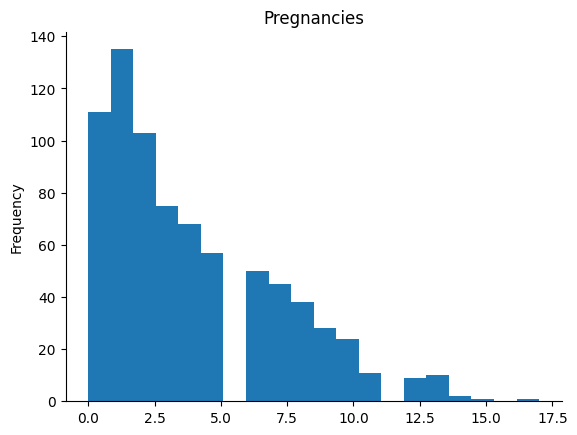

In [134]:
from matplotlib import pyplot as plt
df['Pregnancies'].plot(kind='hist', bins=20, title='Pregnancies')
plt.gca().spines[['top', 'right',]].set_visible(False)

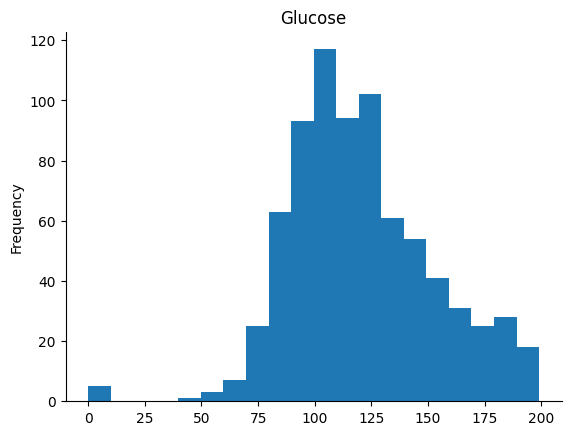

In [135]:
df['Glucose'].plot(kind='hist', bins=20, title='Glucose')
plt.gca().spines[['top', 'right',]].set_visible(False)

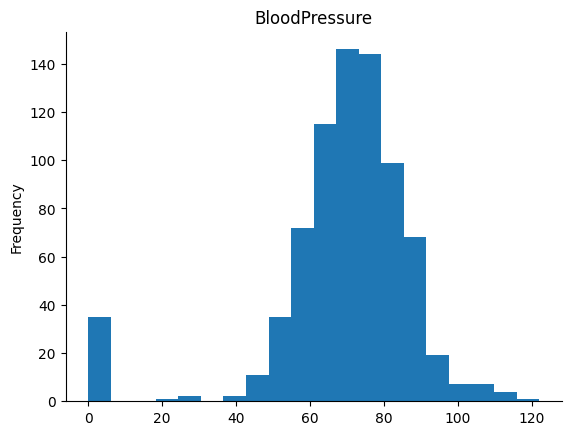

In [136]:
df['BloodPressure'].plot(kind='hist', bins=20, title='BloodPressure')
plt.gca().spines[['top', 'right',]].set_visible(False)

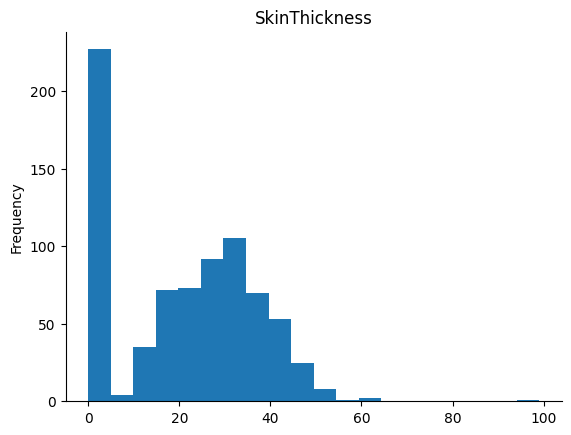

In [137]:
df['SkinThickness'].plot(kind='hist', bins=20, title='SkinThickness')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [138]:
X, y = df.drop(columns=['Outcome'], axis=1), df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [140]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=X)
pca = PCA(n_components=2).fit_transform(X)

Text(0.5, 1.0, 'PCA')

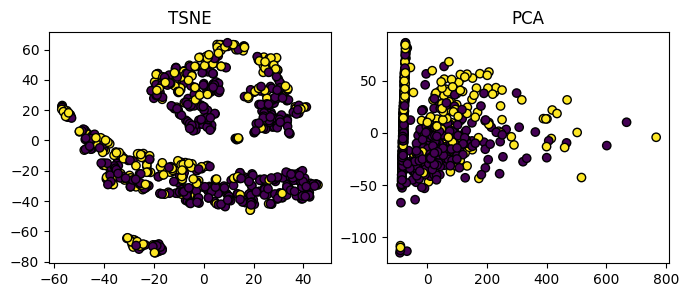

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].scatter(tsne[:, 0], tsne[:, 1], c=y, edgecolor='k')
axes[0].set_title("TSNE")

axes[1].scatter(pca[:, 0], pca[:, 1], c=y, edgecolor='k')
axes[1].set_title("PCA")

In [142]:
class ParzenKNN:
    def __init__(self, k, kernel='gaussian'):
        self.k = k
        self.kernel = kernel

    def gaussian_kernel(self, distances, h):
        return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * (distances / h) ** 2)

    def uniform_kernel(self, distances, h):
        return np.where(distances <= h, 1 / (2 * h), 0)

    def triangular_kernel(self, distances, h):
        return np.where(distances <= h, (1 - distances / h), 0)

    def fit(self, X, y):
        self.X = X
        self.y = y

    def optimal_h(self, nearest_distances):
        return nearest_distances[self.k - 1] if self.k > 0 else 1

    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = cdist([test_point], self.X, metric='euclidean').flatten()
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_distances = distances[nearest_indices]
            nearest_labels = self.y[nearest_indices]

            # Оптимальное значение h
            h = self.optimal_h(nearest_distances)

            # Выбор ядра
            if self.kernel == "gaussian":
                weights = self.gaussian_kernel(nearest_distances, h)
            elif self.kernel == "uniform":
                weights = self.uniform_kernel(nearest_distances, h)
            elif self.kernel == "triangular":
                weights = self.triangular_kernel(nearest_distances, h)
            else:
                raise ValueError("Unknown kernel type")

            label_weights = {}
            for label, weight in zip(nearest_labels, weights):
                label_weights[label] = label_weights.get(label, 0) + weight

            predicted_label = max(label_weights, key=label_weights.get)
            predictions.append(predicted_label)

        return np.array(predictions)

In [143]:
def loo_validation(X, y, k_values):
    errors = []
    for k in k_values:
        model = ParzenKNN(k=k)
        error = 0
        for i in range(len(X)):
            X_train = np.delete(X, i, axis=0)
            y_train = np.delete(y, i)
            X_val = X[i].reshape(1, -1)
            y_val = y[i]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            if y_pred[0] != y_val:
                error += 1

        errors.append(error / len(X) if len(X) > 0 else 0)
    return errors

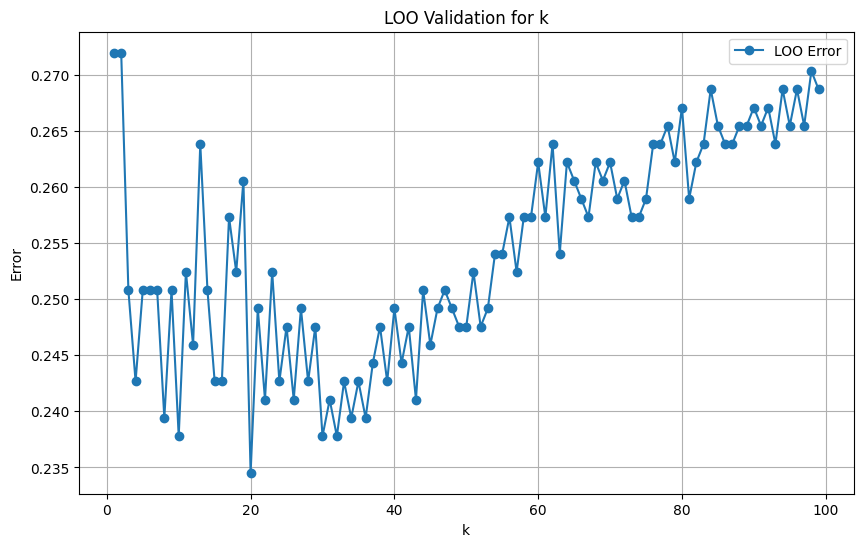

In [144]:
k_values = range(1, 100)
loo_errors = loo_validation(X_train, y_train.to_numpy(), k_values)

# График эмпирического риска
plt.figure(figsize=(10, 6))
plt.plot(k_values, loo_errors, marker='o', label='LOO Error')
plt.xlabel('k')
plt.ylabel('Error')
plt.title('LOO Validation for k')
plt.legend()
plt.grid()
plt.show()

In [145]:
optimal_k = k_values[np.argmin(loo_errors)]
print(f'Optimal k: {optimal_k}')

Optimal k: 20


In [147]:
optimal_k = optimal_k
parzen_knn = ParzenKNN(optimal_k)
parzen_knn.fit(X_train, y_train.to_numpy())

# Предсказание с использованием ParzenKNN
start_time = time.time()
y_pred_custom = parzen_knn.predict(X_test)
custom_time = time.time() - start_time
custom_accuracy = accuracy_score(y_test, y_pred_custom)

# Вычисление метрик для ParzenKNN
custom_precision = precision_score(y_test, y_pred_custom, average='weighted')
custom_recall = recall_score(y_test, y_pred_custom, average='weighted')
custom_f1 = f1_score(y_test, y_pred_custom, average='weighted')

# Инициализация и обучение Scikit-learn KNN
sklearn_knn = KNeighborsClassifier(n_neighbors=90, weights='distance')
sklearn_knn.fit(X_train, y_train)

# Предсказание с использованием Scikit-learn KNN
start_time = time.time()
y_pred_sklearn = sklearn_knn.predict(X_test)
sklearn_time = time.time() - start_time
sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)

# Вычисление метрик для Scikit-learn KNN
sklearn_precision = precision_score(y_test, y_pred_sklearn, average='weighted')
sklearn_recall = recall_score(y_test, y_pred_sklearn, average='weighted')
sklearn_f1 = f1_score(y_test, y_pred_sklearn, average='weighted')

In [148]:
# --- 5. Результаты ---
print(f"Custom ParzenKNN Accuracy: {custom_accuracy:.2f}, Time: {custom_time:.4f} sec")
print(f"Precision: {custom_precision:.2f}, Recall: {custom_recall:.2f}, F1 Score: {custom_f1:.2f}")

print(f"Scikit-learn KNN Accuracy: {sklearn_accuracy:.2f}, Time: {sklearn_time:.4f} sec")
print(f"Precision: {sklearn_precision:.2f}, Recall: {sklearn_recall:.2f}, F1 Score: {sklearn_f1:.2f}")

Custom ParzenKNN Accuracy: 0.75, Time: 0.0751 sec
Precision: 0.75, Recall: 0.75, F1 Score: 0.75
Scikit-learn KNN Accuracy: 0.79, Time: 0.0164 sec
Precision: 0.79, Recall: 0.79, F1 Score: 0.77


In [149]:
# --- 6. Дополнительные метрики ---
print("\nCustom ParzenKNN Classification Report:")
print(classification_report(y_test, y_pred_custom))

print("\nScikit-learn KNN Classification Report:")
print(classification_report(y_test, y_pred_sklearn))


Custom ParzenKNN Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        99
           1       0.70      0.55      0.61        55

    accuracy                           0.75       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154


Scikit-learn KNN Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        99
           1       0.82      0.51      0.63        55

    accuracy                           0.79       154
   macro avg       0.80      0.72      0.74       154
weighted avg       0.79      0.79      0.77       154



In [150]:
# --- 7. Матрица ошибок ---
print("\nCustom ParzenKNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

print("\nScikit-learn KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_sklearn))


Custom ParzenKNN Confusion Matrix:
[[86 13]
 [25 30]]

Scikit-learn KNN Confusion Matrix:
[[93  6]
 [27 28]]


In [153]:
parzen_knn = ParzenKNN(k=optimal_k, kernel='gaussian')
parzen_knn.fit(X_train, y_train.to_numpy())
y_pred_gaussian = parzen_knn.predict(X_test)

# Сравнение с другими ядрами
parzen_knn_uniform = ParzenKNN(k=optimal_k, kernel='uniform')
parzen_knn_uniform.fit(X_train, y_train.to_numpy())
y_pred_uniform = parzen_knn_uniform.predict(X_test)

parzen_knn_triangular = ParzenKNN(k=optimal_k, kernel='triangular')
parzen_knn_triangular.fit(X_train, y_train.to_numpy())
y_pred_triangular = parzen_knn_triangular.predict(X_test)

In [154]:
# Расчет accuracy для каждого метода
acc_gaussian = accuracy_score(y_test, y_pred_gaussian)
acc_uniform = accuracy_score(y_test, y_pred_uniform)
acc_triangular = accuracy_score(y_test, y_pred_triangular)

print("Accuracy Gaussian Kernel:", acc_gaussian)
print("Accuracy Uniform Kernel:", acc_uniform)
print("Accuracy Triangular Kernel:", acc_triangular)

Accuracy Gaussian Kernel: 0.7532467532467533
Accuracy Uniform Kernel: 0.7662337662337663
Accuracy Triangular Kernel: 0.6948051948051948
